<a href="https://colab.research.google.com/github/dongjae-shin/Ab_initio_thermo_HgOx/blob/main/ab_initio_thermo_HgOx.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **1. Preparation**

## **1. 1. Data Loading (depreciated)**

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
# path = 'drive/My Drive/CCEL/ab-initio_thermo'
# import sys
# sys.path.append(path)

## **1. 2. Modules Loading**

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
# import utils as ut

# **2. Basic Parameters Setting**

In [ ]:
# Setting several parameters for the calculation of free energies
kB = 8.6180e-5              # eV/K
A = 58.8136                 # Ang^2
po = 0.9869                 # atm

E_TiO2001 = -310.4724       # eV

E_octa    = -433.8083       # eV, Ti12O24 + V4O12
E_octa_1h = -439.6937       # eV, Ti12O24 + V4O12H1
E_octa_2h = -446.5517       # eV, Ti12O24 + V4O12H2
E_octa_3h = -452.0346       # eV, Ti12O24 + V4O12H3
E_octa_h  = -457.9192       # eV, Ti12O24 + V4O12H4

E_tetra    = -428.1933      # eV, Ti12O24 + V4O10
E_tetra_1h = -432.2982      # eV, Ti12O24 + V4O10H1
E_tetra_2h = -437.2132      # eV, Ti12O24 + V4O10H2
E_tetra_3h = -440.9767      # eV, Ti12O24 + V4O10H3
E_tetra_h  = -444.0092      # eV, Ti12O24 + V4O10H4

E_O2   = -9.8586            # eV
E_H2   = -6.7702            # eV
E_H2O  = -14.2186           # eV
E_Vbcc = -8.9402            # eV

ZPE_O2   = 0.1131           # eV
ZPE_H2   = 0.2894           # eV
ZPE_H2O  = 0.5744           # eV
ZPE_Vbcc = 0.0225           # eV. wrong

# **3. Definitions of Functions**

In [ ]:
# Definitions of T,p-dependent functions
def delta_mu_O2(T,pO2):
  delmu_T = -9.4667e-20*T**6 \
            +6.4562e-16*T**5 \
            -1.7447e-12*T**4 \
            +2.4199e-9*T**3 \
            -2.0310e-6*T**2 \
            -1.3962e-3*T \
            +2.5114e-3
  delmu_p = kB*T*np.log(pO2/po)

  return delmu_T+delmu_p

def delta_mu_H2O(T,pH2O):
  delmu_T = -1.0761e-19*T**6 \
            +7.3862e-16*T**5 \
            -2.0094e-12*T**4 \
            +2.7972e-9*T**3 \
            -2.3445e-6*T**2 \
            -1.1163e-3*T \
            +2.6346e-3
  delmu_p = kB*T*np.log(pH2O/po)

  return delmu_T+delmu_p

def delta_mu_H2(T,pH2):
  delmu_T = -9.1827e-20*T**6 \
            +6.2921e-16*T**5 \
            -1.7123e-12*T**4 \
            +2.3948e-9*T**3 \
            -2.0038e-6*T**2 \
            -6.3855e-4*T \
            +2.5410e-3
  delmu_p = kB*T*np.log(pH2/po)

  return delmu_T+delmu_p

def delta_mu_V(T,pV):
  delmu_T = -9.7720e-21*T**6 \
            +8.3312e-17*T**5 \
            -2.9672e-13*T**4 \
            +5.8361e-10*T**3 \
            -8.1121e-7*T**2 \
            +5.8611e-5*T \
            -1.7483e-4
  delmu_p = kB*T*np.log(pV/po)

  return delmu_T+delmu_p

# Definition of vib. free energy
def F_vib(T, vib_E, vib_free=False):
  # vib_E = hv_i in eV
  # JPCC, 2014, 118, 8491-8500
  first_term = 0.5*sum(vib_E)
  if vib_free:
    second_term = sum(kB*T*np.log(1-np.exp(-vib_E/kB/T)))
  else:
    second_term = 0.0

  return first_term + second_term

# Definition of T,p-dependent free energy
def deltaG_form(Ecatal, T, pO2, pH2O, x, y, z):
  deltaG_form = (A**-1)*(Ecatal-E_TiO2001
                         -x*(E_Vbcc)
                         -(y-0.5*z)*0.5*(E_O2+ZPE_O2+delta_mu_O2(T,pO2))
                         -0.5*z*(E_H2O+ZPE_H2O+delta_mu_H2O(T,pH2O)))
  return deltaG_form

# Free energy of formation based on H2O gas as a function of chemical potential
# difference
def deltaG_form_mu(Ecatal, delta_muV, delta_muO2, delta_muH2O, x, y, z):
  deltaG_form = (A**-1)*(Ecatal-E_TiO2001
                         -x*(E_Vbcc+delta_muV)
                         -(y-0.5*z)*0.5*(E_O2+ZPE_O2+delta_muO2)
                         -0.5*z*(E_H2O+ZPE_H2O+delta_muH2O))
  return deltaG_form

# Free energy of formation based on H2O gas as a function of chemical potential
# difference
def deltaG_form_mu_H2O(Ecatal, delta_muO2, delta_muH2O, x, y, z):
  deltaG_form = (A**-1)*(Ecatal-E_TiO2001
                         -x*E_Vbcc
                         -(y-0.5*z)*0.5*(E_O2+ZPE_O2+delta_muO2)
                         -0.5*z*(E_H2O+ZPE_H2O+delta_muH2O))
  return deltaG_form

# Free energy of formation based on H2 gas as a function of chemical potential
# difference
def deltaG_form_mu_H2(Ecatal, delta_muO2, delta_muH2, x, y, z):
  deltaG_form = (A**-1)*(Ecatal-E_TiO2001
                         -x*E_Vbcc
                         -y*0.5*(E_O2+ZPE_O2+delta_muO2)
                         -z*0.5*(E_H2+ZPE_H2+delta_muH2))
  return deltaG_form

vibrational free energies of molecules

In [ ]:
vib_E_O2 = np.array([186.239156, 19.990756, 19.980675])/1000 # eV
vib_E_H2O = np.array([482.654105, 469.166067, 195.667854, 0.849994, 0.394399])/1000 # eV
vib_E_H2 = np.array([470.332590, 122.388089, 122.383494])/1000 # eV

In [ ]:
vib_E_H2O

array([4.82654105e-01, 4.69166067e-01, 1.95667854e-01, 8.49994000e-04,
       3.94399000e-04])

In [ ]:
#T_test = np.linspace(0,1100, 111)
T_test = [673, 773, 873, 973, 1073]
for T in T_test:
  print(F_vib(T, vib_E_O2, vib_free=True), "eV")
  # print(F_vib(T, vib_E_H2, vib_free=True), "eV")
  # print(F_vib(T, vib_E_H2O, vib_free=True), "eV")

-0.032279451899319855 eV
-0.07098591001230378 eV
-0.11251324054740233 eV
-0.15661311908223227 eV
-0.20307496856440035 eV


### **3.1 Definitions of Functions of Four-phased Diagram**

In [ ]:
# Definition of functions of minimum free energy surface
def labeled_deltaG(delta_muO2, delta_muH2):
  G1 = deltaG_form_mu_H2(E_octa,  delta_muO2, delta_muH2, 4, 12, 0)
  G2 = deltaG_form_mu_H2(E_octa_h, delta_muO2, delta_muH2, 4, 12, 4)
  G3 = deltaG_form_mu_H2(E_tetra, delta_muO2, delta_muH2, 4, 10, 0)
  G4 = deltaG_form_mu_H2(E_tetra_h, delta_muO2, delta_muH2, 4, 10, 4)

  Gmin1 = np.minimum(G1, G2)
  Gmin2 = np.minimum(G3, G4)
  Gmin = np.minimum(Gmin1, Gmin2) # element-wise minimum of two arrays

  for i in range(len(delta_muO2)):
    for j in range(len(delta_muH2)):
      if Gmin[i][j] == G1[i][j]:
        Gmin[i][j] = 1
      elif Gmin[i][j] == G2[i][j]:
        Gmin[i][j] = 2
      elif Gmin[i][j] == G3[i][j]:
        Gmin[i][j] = 3
      elif Gmin[i][j] == G4[i][j]:
        Gmin[i][j] = 4
      else:
        print("not matched!")

  return Gmin

def min_deltaG(delta_muO2, delta_muH2):
  G1 = deltaG_form_mu_H2(E_octa,  delta_muO2, delta_muH2, 4, 12, 0)
  G2 = deltaG_form_mu_H2(E_octa_h, delta_muO2, delta_muH2, 4, 12, 4)
  G3 = deltaG_form_mu_H2(E_tetra, delta_muO2, delta_muH2, 4, 10, 0)
  G4 = deltaG_form_mu_H2(E_tetra_h, delta_muO2, delta_muH2, 4, 10, 4)

  Gmin1 = np.minimum(G1, G2) # supported up to 2 arrays at a time
  Gmin2 = np.minimum(G3, G4)
  Gmin = np.minimum(Gmin1, Gmin2) # element-wise minimum of two arrays

  return Gmin

# **4. Phase Diagrams**

## **4. 1. Four-phased Diagram**

In [ ]:
delta_muO2 = np.linspace(-10,10,1000)
delta_muH2 = np.linspace(-10,10,1000)

delta_muO2, delta_muH2 = np.meshgrid(delta_muO2, delta_muH2)

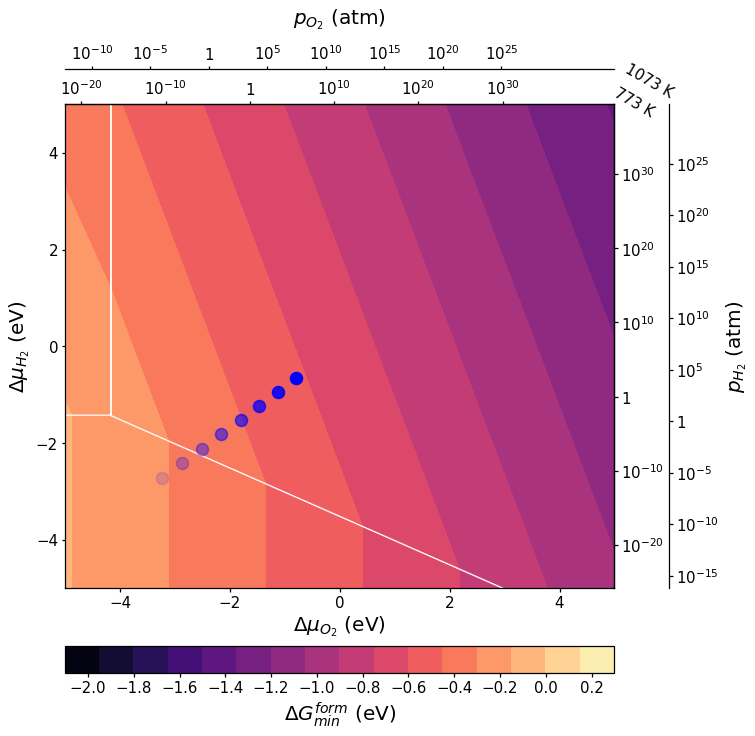

In [ ]:
plt.rcParams["font.family"] = "sans-serif"
borderwidth = 1.25
linewidth = 1.25

# Set overall size of figure
fig = plt.figure(figsize=(10.6,10.5))
# ax = fig.gca(projection='3d')
ax = fig.add_subplot(111)
ax.set_xlim(left=-5.0, right=5.0)
ax.set_ylim(bottom=-5.0, top=5.0)

Gmin_labeled = labeled_deltaG(delta_muO2, delta_muH2) # get labeled Gmin
Gmin_min = min_deltaG(delta_muO2, delta_muH2) # get continuous Gmin

# plt.imshow(Gmin, interpolation='gaussian')

# plane1 = ax.contourf(delta_muO2, delta_muH2, Gmin_labeled,
#                     cmap="ocean", levels=[0, 0.5, 1.5, 2.5, 3.5, 4.5],
#                     alpha=1,
#                     antialiased=False)
''' Many Color Maps:
ValueError: 'io' is not a valid value for name; supported values are 'Accent',
 'Accent_r', 'Blues', 'Blues_r', 'BrBG', 'BrBG_r', 'BuGn', 'BuGn_r', 'BuPu',
  'BuPu_r', 'CMRmap', 'CMRmap_r', 'Dark2', 'Dark2_r', 'GnBu', 'GnBu_r',
   'Greens', 'Greens_r', 'Greys', 'Greys_r', 'OrRd', 'OrRd_r', 'Oranges',
    'Oranges_r', 'PRGn', 'PRGn_r', 'Paired', 'Paired_r', 'Pastel1', 'Pastel1_r',
     'Pastel2', 'Pastel2_r', 'PiYG', 'PiYG_r', 'PuBu', 'PuBuGn', 'PuBuGn_r',
      'PuBu_r', 'PuOr', 'PuOr_r', 'PuRd', 'PuRd_r', 'Purples', 'Purples_r',
       'RdBu', 'RdBu_r', 'RdGy', 'RdGy_r', 'RdPu', 'RdPu_r', 'RdYlBu',
       'RdYlBu_r', 'RdYlGn', 'RdYlGn_r', 'Reds', 'Reds_r', 'Set1', 'Set1_r',
       'Set2', 'Set2_r', 'Set3', 'Set3_r', 'Spectral', 'Spectral_r', 'Wistia',
        'Wistia_r', 'YlGn', 'YlGnBu', 'YlGnBu_r', 'YlGn_r', 'YlOrBr', 'YlOrBr_r'
        , 'YlOrRd', 'YlOrRd_r', 'afmhot', 'afmhot_r', 'autumn', 'autumn_r',
         'binary', 'binary_r', 'bone', 'bone_r', 'brg', 'brg_r', 'bwr', 'bwr_r'
         , 'cividis', 'cividis_r', 'cool', 'cool_r', 'coolwarm', 'coolwarm_r'
         , 'copper', 'copper_r', 'cubehelix', 'cubehelix_r', 'flag', 'flag_r',
          'gist_earth', 'gist_earth_r', 'gist_gray', 'gist_gray_r', 'gist_heat',
           'gist_heat_r', 'gist_ncar', 'gist_ncar_r', 'gist_rainbow',
            'gist_rainbow_r', 'gist_stern', 'gist_stern_r', 'gist_yarg',
            'gist_yarg_r', 'gnuplot', 'gnuplot2', 'gnuplot2_r', 'gnuplot_r',
             'gray', 'gray_r', 'hot', 'hot_r', 'hsv', 'hsv_r', 'inferno',
              'inferno_r', 'jet', 'jet_r', 'magma', 'magma_r', 'nipy_spectral',
               'nipy_spectral_r', 'ocean', 'ocean...
'''
plane2 = ax.contourf(delta_muO2, delta_muH2, Gmin_min,
                    cmap="magma", alpha=1.0, levels=20,
                    antialiased=False,)

line1 = ax.contour(delta_muO2, delta_muH2, Gmin_labeled, linestyles=['solid',],
                  levels=[0, 0.5, 1.5, 2.5, 3.5, 4.5],linewidths=linewidth, colors=['w',])
line2 = ax.contour(delta_muO2, delta_muH2, Gmin_min, linestyles=['dashed',],
                  levels=[0,],linewidths=1.5, colors=['w',])
# ax.clabel(line2, line2.levels, inline=True, fmt='$\Delta G^{form}$ = %1.1f eV',
#           fontsize=15, inline_spacing=15)

for temp in [1073, 973, 873, 773, 673, 573, 473, 373, 273]:
  point = plt.plot(delta_mu_O2(temp,0.20946e-5*po),
                   delta_mu_H2(temp,1e-7*po),
                   'bo-', markersize=12, mew=1.5, alpha=((1073-temp)/800))
  # position of common experimental condition

ax.set_xlabel('$\Delta \mu_{O_2}$ (eV)', size=20)
ax.set_ylabel('$\Delta \mu_{H_2}$ (eV)', size=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

for axis in ['top','bottom','left','right']:
  ax.spines[axis].set_linewidth(borderwidth)

ax.xaxis.set_tick_params(width=borderwidth)
ax.yaxis.set_tick_params(width=borderwidth)

# Second x axis
ax2 = ax.twiny() # xaxis for p@773K
ax3 = ax.twiny() # xaxis for p@1073K

p_values_773 = [1e-20, 1e-10, 1, 1e10, 1e20, 1e30] # labels of the xticklabels: the position in the new x-axis
p_labels_773 = ['$10^{-20}$', '$10^{-10}$', '$1$', '$10^{10}$', '$10^{20}$', '$10^{30}$']
# k2degc = lambda t: t-273.15 # convert function: from Kelvin to Degree Celsius
# newpos   = [k2degc(t) for t in newlabel]   # position of the xticklabels in the old x-axis
newpos_at_773 = [delta_mu_O2(773, p) for p in p_values_773]
ax2.set_xticks(newpos_at_773)
ax2.set_xticklabels(p_labels_773)
ax2.xaxis.set_ticks_position('top') # set the position of the second x-axis to bottom
ax2.xaxis.set_label_position('top') # set the position of the second x-axis to bottom
# ax2.set_xlabel('Temperature [K]')
ax2.set_xlim(ax.get_xlim())
# ax2.spines['top'].set_position(('outward', 66))
ax2.spines['top'].set_linewidth(borderwidth)
ax2.tick_params(labelsize=15, width=borderwidth)

p_values_1073 = [1e-15, 1e-10, 1e-5, 1, 1e5, 1e10, 1e15, 1e20, 1e25] # labels of the xticklabels: the position in the new x-axis
p_labels_1073 = ['$10^{-15}$', '$10^{-10}$', '$10^{-5}$', '$1$', '$10^{5}$', '$10^{10}$', '$10^{15}$', '$10^{20}$', '$10^{25}$']
newpos_at_1073 = [delta_mu_O2(1073, p) for p in p_values_1073]
ax3.set_xticks(newpos_at_1073)
ax3.set_xticklabels(p_labels_1073)
ax3.xaxis.set_ticks_position('top') # set the position of the second x-axis to bottom
ax3.xaxis.set_label_position('top') # set the position of the second x-axis to bottom
ax3.set_xlabel('$p_{O_2}$ (atm)', size=20, labelpad=20)
ax3.set_xlim(ax.get_xlim())
ax3.spines['top'].set_position(('outward', 35))
ax3.spines['top'].set_linewidth(borderwidth)
ax3.tick_params(labelsize=15, width=borderwidth)

# Second y axis
ax4 = ax.twinx() # xaxis for p@773K
ax5 = ax.twinx() # xaxis for p@1073K

newpos_at_773 = [delta_mu_H2(773, p) for p in p_values_773]
ax4.set_yticks(newpos_at_773)
ax4.set_yticklabels(p_labels_773)
ax4.yaxis.set_ticks_position('right') # set the position of the second x-axis to bottom
ax4.yaxis.set_label_position('right') # set the position of the second x-axis to bottom
ax4.set_ylim(ax.get_ylim())
ax4.spines['right'].set_linewidth(borderwidth)
ax4.tick_params(labelsize=15, width=borderwidth)

newpos_at_1073 = [delta_mu_H2(1073, p) for p in p_values_1073]
ax5.set_yticks(newpos_at_1073)
ax5.set_yticklabels(p_labels_1073)
ax5.yaxis.set_ticks_position('right') # set the position of the second x-axis to bottom
ax5.yaxis.set_label_position('right') # set the position of the second x-axis to bottom
ax5.set_ylabel('$p_{H_2}$ (atm)', size=20, labelpad=5)
ax5.set_ylim(ax.get_ylim())
ax5.spines['right'].set_position(('outward', 55))
ax5.spines['right'].set_linewidth(borderwidth)
ax5.tick_params(labelsize=15, width=borderwidth)

# Texts
plt.text(4.95, 4.75,'773 K', fontsize=15, rotation=-30)
plt.text(5.15, 5.15,'1073 K', fontsize=15, rotation=-30)

# Colorbar
cbar = fig.colorbar(plane2, orientation='horizontal',
                    ticks=np.linspace(-2.0,0.2,12),
                    pad=0.09)
cbar.outline.set_linewidth(borderwidth)
cbar.set_label('$\Delta G^{form}_{min}$ (eV)', fontsize=20, labelpad=5)
cbar.ax.tick_params(labelsize=15, width=borderwidth)
fig.tight_layout()
plt.show()

## **4. 2. Definitions of Functions of Ten-phased Diagram**

In [ ]:
# Definition of functions of minimum free energy surface
def labeled_deltaG(delta_muO2, delta_muH2):
  G1 = deltaG_form_mu_H2(E_octa,     delta_muO2, delta_muH2, 4, 12, 0)
  G2 = deltaG_form_mu_H2(E_octa_1h,  delta_muO2, delta_muH2, 4, 12, 1)
  G3 = deltaG_form_mu_H2(E_octa_2h,  delta_muO2, delta_muH2, 4, 12, 2)
  G4 = deltaG_form_mu_H2(E_octa_3h,  delta_muO2, delta_muH2, 4, 12, 3)
  G5 = deltaG_form_mu_H2(E_octa_h,   delta_muO2, delta_muH2, 4, 12, 4) # octa_4h
  G6 = deltaG_form_mu_H2(E_tetra,    delta_muO2, delta_muH2, 4, 10, 0)
  G7 = deltaG_form_mu_H2(E_tetra_1h, delta_muO2, delta_muH2, 4, 10, 1)
  G8 = deltaG_form_mu_H2(E_tetra_2h, delta_muO2, delta_muH2, 4, 10, 2)
  G9 = deltaG_form_mu_H2(E_tetra_3h, delta_muO2, delta_muH2, 4, 10, 3)
  G10= deltaG_form_mu_H2(E_tetra_h,  delta_muO2, delta_muH2, 4, 10, 4) # tetra_4h

  Gmin = np.minimum(G1,   G2) # element-wise minimum of two arrays
  Gmin = np.minimum(Gmin, G3)
  Gmin = np.minimum(Gmin, G4)
  Gmin = np.minimum(Gmin, G5)
  Gmin = np.minimum(Gmin, G6)
  Gmin = np.minimum(Gmin, G7)
  Gmin = np.minimum(Gmin, G8)
  Gmin = np.minimum(Gmin, G9)
  Gmin = np.minimum(Gmin, G10)

  for i in range(len(delta_muO2)):
    for j in range(len(delta_muH2)):
      if Gmin[i][j] == G1[i][j]:
        Gmin[i][j] = 1
      elif Gmin[i][j] == G2[i][j]:
        Gmin[i][j] = 2
      elif Gmin[i][j] == G3[i][j]:
        Gmin[i][j] = 3
      elif Gmin[i][j] == G4[i][j]:
        Gmin[i][j] = 4
      elif Gmin[i][j] == G5[i][j]:
        Gmin[i][j] = 5
      elif Gmin[i][j] == G6[i][j]:
        Gmin[i][j] = 6
      elif Gmin[i][j] == G7[i][j]:
        Gmin[i][j] = 7
      elif Gmin[i][j] == G8[i][j]:
        Gmin[i][j] = 8
      elif Gmin[i][j] == G9[i][j]:
        Gmin[i][j] = 9
      elif Gmin[i][j] == G10[i][j]:
        Gmin[i][j] = 10
      else:
        print("not matched!")

  return Gmin

def min_deltaG(delta_muO2, delta_muH2):
  G1 = deltaG_form_mu_H2(E_octa,     delta_muO2, delta_muH2, 4, 12, 0)
  G2 = deltaG_form_mu_H2(E_octa_1h,  delta_muO2, delta_muH2, 4, 12, 1)
  G3 = deltaG_form_mu_H2(E_octa_2h,  delta_muO2, delta_muH2, 4, 12, 2)
  G4 = deltaG_form_mu_H2(E_octa_3h,  delta_muO2, delta_muH2, 4, 12, 3)
  G5 = deltaG_form_mu_H2(E_octa_h,   delta_muO2, delta_muH2, 4, 12, 4) # octa_4h
  G6 = deltaG_form_mu_H2(E_tetra,    delta_muO2, delta_muH2, 4, 10, 0)
  G7 = deltaG_form_mu_H2(E_tetra_1h, delta_muO2, delta_muH2, 4, 10, 1)
  G8 = deltaG_form_mu_H2(E_tetra_2h, delta_muO2, delta_muH2, 4, 10, 2)
  G9 = deltaG_form_mu_H2(E_tetra_3h, delta_muO2, delta_muH2, 4, 10, 3)
  G10= deltaG_form_mu_H2(E_tetra_h,  delta_muO2, delta_muH2, 4, 10, 4) # tetra_4h

  Gmin = np.minimum(G1,   G2) # element-wise minimum of two arrays
  Gmin = np.minimum(Gmin, G3)
  Gmin = np.minimum(Gmin, G4)
  Gmin = np.minimum(Gmin, G5)
  Gmin = np.minimum(Gmin, G6)
  Gmin = np.minimum(Gmin, G7)
  Gmin = np.minimum(Gmin, G8)
  Gmin = np.minimum(Gmin, G9)
  Gmin = np.minimum(Gmin, G10)

  return Gmin

## **4. 3. Ten-phased Diagram**

In [ ]:
delta_muO2 = np.linspace(-10,10,3000)
delta_muH2 = np.linspace(-10,10,3000)

delta_muO2, delta_muH2 = np.meshgrid(delta_muO2, delta_muH2)

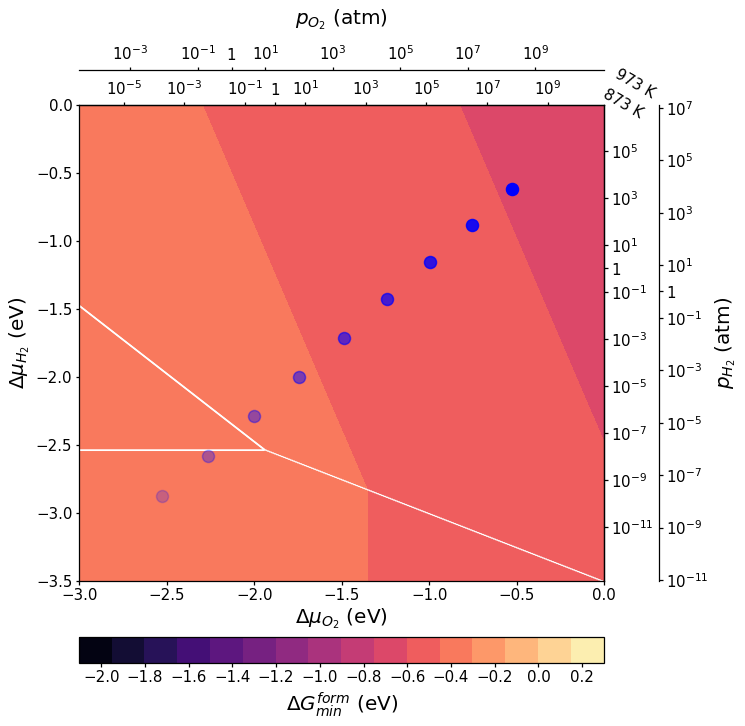

In [ ]:
plt.rcParams["font.family"] = "sans-serif"
borderwidth = 1.25
linewidth = 1.25

# Set overall size of figure
fig = plt.figure(figsize=(10.6,10.5))
# ax = fig.gca(projection='3d')
ax = fig.add_subplot(111)
ax.set_xlim(left=-3, right=0)
ax.set_ylim(bottom=-3.5, top=0)
# ax.set_xlim(left=-5, right=5.0)
# ax.set_ylim(bottom=-5, top=5.0)

# Generation of delG Data
Gmin_labeled = labeled_deltaG(delta_muO2, delta_muH2) # get labeled Gmin
Gmin_min = min_deltaG(delta_muO2, delta_muH2) # get continuous Gmin

# plt.imshow(Gmin, interpolation='gaussian')

# plane1 = ax.contourf(delta_muO2, delta_muH2, Gmin_labeled,
#                     cmap="ocean", levels=[0, 0.5, 1.5, 2.5, 3.5, 4.5],
#                     alpha=1,
#                     antialiased=False)
''' Many Color Maps:
ValueError: 'io' is not a valid value for name; supported values are 'Accent',
 'Accent_r', 'Blues', 'Blues_r', 'BrBG', 'BrBG_r', 'BuGn', 'BuGn_r', 'BuPu',
  'BuPu_r', 'CMRmap', 'CMRmap_r', 'Dark2', 'Dark2_r', 'GnBu', 'GnBu_r',
   'Greens', 'Greens_r', 'Greys', 'Greys_r', 'OrRd', 'OrRd_r', 'Oranges',
    'Oranges_r', 'PRGn', 'PRGn_r', 'Paired', 'Paired_r', 'Pastel1', 'Pastel1_r',
     'Pastel2', 'Pastel2_r', 'PiYG', 'PiYG_r', 'PuBu', 'PuBuGn', 'PuBuGn_r',
      'PuBu_r', 'PuOr', 'PuOr_r', 'PuRd', 'PuRd_r', 'Purples', 'Purples_r',
       'RdBu', 'RdBu_r', 'RdGy', 'RdGy_r', 'RdPu', 'RdPu_r', 'RdYlBu',
       'RdYlBu_r', 'RdYlGn', 'RdYlGn_r', 'Reds', 'Reds_r', 'Set1', 'Set1_r',
       'Set2', 'Set2_r', 'Set3', 'Set3_r', 'Spectral', 'Spectral_r', 'Wistia',
        'Wistia_r', 'YlGn', 'YlGnBu', 'YlGnBu_r', 'YlGn_r', 'YlOrBr', 'YlOrBr_r'
        , 'YlOrRd', 'YlOrRd_r', 'afmhot', 'afmhot_r', 'autumn', 'autumn_r',
         'binary', 'binary_r', 'bone', 'bone_r', 'brg', 'brg_r', 'bwr', 'bwr_r'
         , 'cividis', 'cividis_r', 'cool', 'cool_r', 'coolwarm', 'coolwarm_r'
         , 'copper', 'copper_r', 'cubehelix', 'cubehelix_r', 'flag', 'flag_r',
          'gist_earth', 'gist_earth_r', 'gist_gray', 'gist_gray_r', 'gist_heat',
           'gist_heat_r', 'gist_ncar', 'gist_ncar_r', 'gist_rainbow',
            'gist_rainbow_r', 'gist_stern', 'gist_stern_r', 'gist_yarg',
            'gist_yarg_r', 'gnuplot', 'gnuplot2', 'gnuplot2_r', 'gnuplot_r',
             'gray', 'gray_r', 'hot', 'hot_r', 'hsv', 'hsv_r', 'inferno',
              'inferno_r', 'jet', 'jet_r', 'magma', 'magma_r', 'nipy_spectral',
               'nipy_spectral_r', 'ocean', 'ocean...
'''
# Labeled minimum surface of delG
plane2 = ax.contourf(delta_muO2, delta_muH2, Gmin_min,
                    cmap="magma", alpha=1.0, levels=20,
                    antialiased=False,)

# Phase boundaries
line1 = ax.contour(delta_muO2, delta_muH2, Gmin_labeled, linestyles=['solid',],
                  levels=[0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5, 8.5, 9.5, 10.5],
                  linewidths=linewidth, colors=['w',])

# Contour line for delG = 0
line2 = ax.contour(delta_muO2, delta_muH2, Gmin_min, linestyles=['dashed',],
                  levels=[0,],linewidths=1.5, colors=['k',])
ax.clabel(line2, line2.levels, inline=True, fmt='$\Delta G^{form}_{min}$ = %1.1f eV',
          fontsize=15, inline_spacing=15, manual=[(-7,-6.3),])

# Temperature trajectory
for temp in [1073, 973, 873, 773, 673, 573, 473, 373, 273]:
  point = plt.plot(delta_mu_O2(temp,0.20946*po),
                   delta_mu_H2(temp,5.5e-7*po),
                   'bo-', markersize=12, mew=1.5, alpha=((1273-temp)/1000))
  # position of common experimental condition

# Plot labels
ax.set_xlabel('$\Delta \mu_{O_2}$ (eV)', size=20)
ax.set_ylabel('$\Delta \mu_{H_2}$ (eV)', size=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

for axis in ['top','bottom','left','right']:
  ax.spines[axis].set_linewidth(borderwidth)

ax.xaxis.set_tick_params(width=borderwidth)
ax.yaxis.set_tick_params(width=borderwidth)

# Second x axis
ax2 = ax.twiny() # xaxis for p@673K
ax3 = ax.twiny() # xaxis for p@1073K

p_values_873 = [1e-11, 1e-9, 1e-7, 1e-5, 1e-3, 1e-1, 1, 1e1, 1e3, 1e5, 1e7, 1e9, 1e12] # labels of the xticklabels: the position in the new x-axis
p_labels_873 = ['$10^{-11}$', '$10^{-9}$', '$10^{-7}$', '$10^{-5}$', '$10^{-3}$', '$10^{-1}$', '$1$', '$10^{1}$', '$10^{3}$', '$10^{5}$', '$10^{7}$', '$10^{9}$', '$10^{12}$']
# k2degc = lambda t: t-273.15 # convert function: from Kelvin to Degree Celsius
# newpos   = [k2degc(t) for t in newlabel]   # position of the xticklabels in the old x-axis
newpos_at_873 = [delta_mu_O2(873, p) for p in p_values_873]
ax2.set_xticks(newpos_at_873)
ax2.set_xticklabels(p_labels_873)
ax2.xaxis.set_ticks_position('top') # set the position of the second x-axis to bottom
ax2.xaxis.set_label_position('top') # set the position of the second x-axis to bottom
# ax2.set_xlabel('Temperature [K]')
ax2.set_xlim(ax.get_xlim())
# ax2.spines['top'].set_position(('outward', 66))
ax2.spines['top'].set_linewidth(borderwidth)
ax2.tick_params(labelsize=15, width=borderwidth)

p_values_973 = [1e-11, 1e-9, 1e-7, 1e-5, 1e-3, 1e-1, 1, 1e1, 1e3, 1e5, 1e7, 1e9] # labels of the xticklabels: the position in the new x-axis
p_labels_973 = ['$10^{-11}$', '$10^{-9}$', '$10^{-7}$', '$10^{-5}$', '$10^{-3}$', '$10^{-1}$', '$1$', '$10^{1}$', '$10^{3}$', '$10^{5}$', '$10^{7}$', '$10^{9}$']
newpos_at_973 = [delta_mu_O2(973, p) for p in p_values_973]
ax3.set_xticks(newpos_at_973)
ax3.set_xticklabels(p_labels_973)
ax3.xaxis.set_ticks_position('top') # set the position of the second x-axis to bottom
ax3.xaxis.set_label_position('top') # set the position of the second x-axis to bottom
ax3.set_xlabel('$p_{O_2}$ (atm)', size=20, labelpad=20)
ax3.set_xlim(ax.get_xlim())
ax3.spines['top'].set_position(('outward', 35))
ax3.spines['top'].set_linewidth(borderwidth)
ax3.tick_params(labelsize=15, width=borderwidth)

# Second y axis
ax4 = ax.twinx() # xaxis for p@673K
ax5 = ax.twinx() # xaxis for p@1073K

newpos_at_873 = [delta_mu_H2(873, p) for p in p_values_873]
ax4.set_yticks(newpos_at_873)
ax4.set_yticklabels(p_labels_873)
ax4.yaxis.set_ticks_position('right') # set the position of the second x-axis to bottom
ax4.yaxis.set_label_position('right') # set the position of the second x-axis to bottom
ax4.set_ylim(ax.get_ylim())
ax4.spines['right'].set_linewidth(borderwidth)
ax4.tick_params(labelsize=15, width=borderwidth)

newpos_at_973 = [delta_mu_H2(973, p) for p in p_values_973]
ax5.set_yticks(newpos_at_973)
ax5.set_yticklabels(p_labels_973)
ax5.yaxis.set_ticks_position('right') # set the position of the second x-axis to bottom
ax5.yaxis.set_label_position('right') # set the position of the second x-axis to bottom
ax5.set_ylabel('$p_{H_2}$ (atm)', size=20, labelpad=5)
ax5.set_ylim(ax.get_ylim())
ax5.spines['right'].set_position(('outward', 55))
ax5.spines['right'].set_linewidth(borderwidth)
ax5.tick_params(labelsize=15, width=borderwidth)

# Texts
plt.text(-0.02, -0.10,'873 K', fontsize=15, rotation=-30)
plt.text(0.05, 0.05,'973 K', fontsize=15, rotation=-30)

# Colorbar
cbar = fig.colorbar(plane2, orientation='horizontal',
                    ticks=np.linspace(-2.0,0.2,12),
                    pad=0.09)
cbar.outline.set_linewidth(borderwidth)
cbar.set_label('$\Delta G^{form}_{min}$ (eV)', fontsize=20, labelpad=5)
cbar.ax.tick_params(labelsize=15, width=borderwidth)
fig.tight_layout()
plt.show()

### **4. 3. 1. Checking Where 1h Models are Relative to Min Surface**

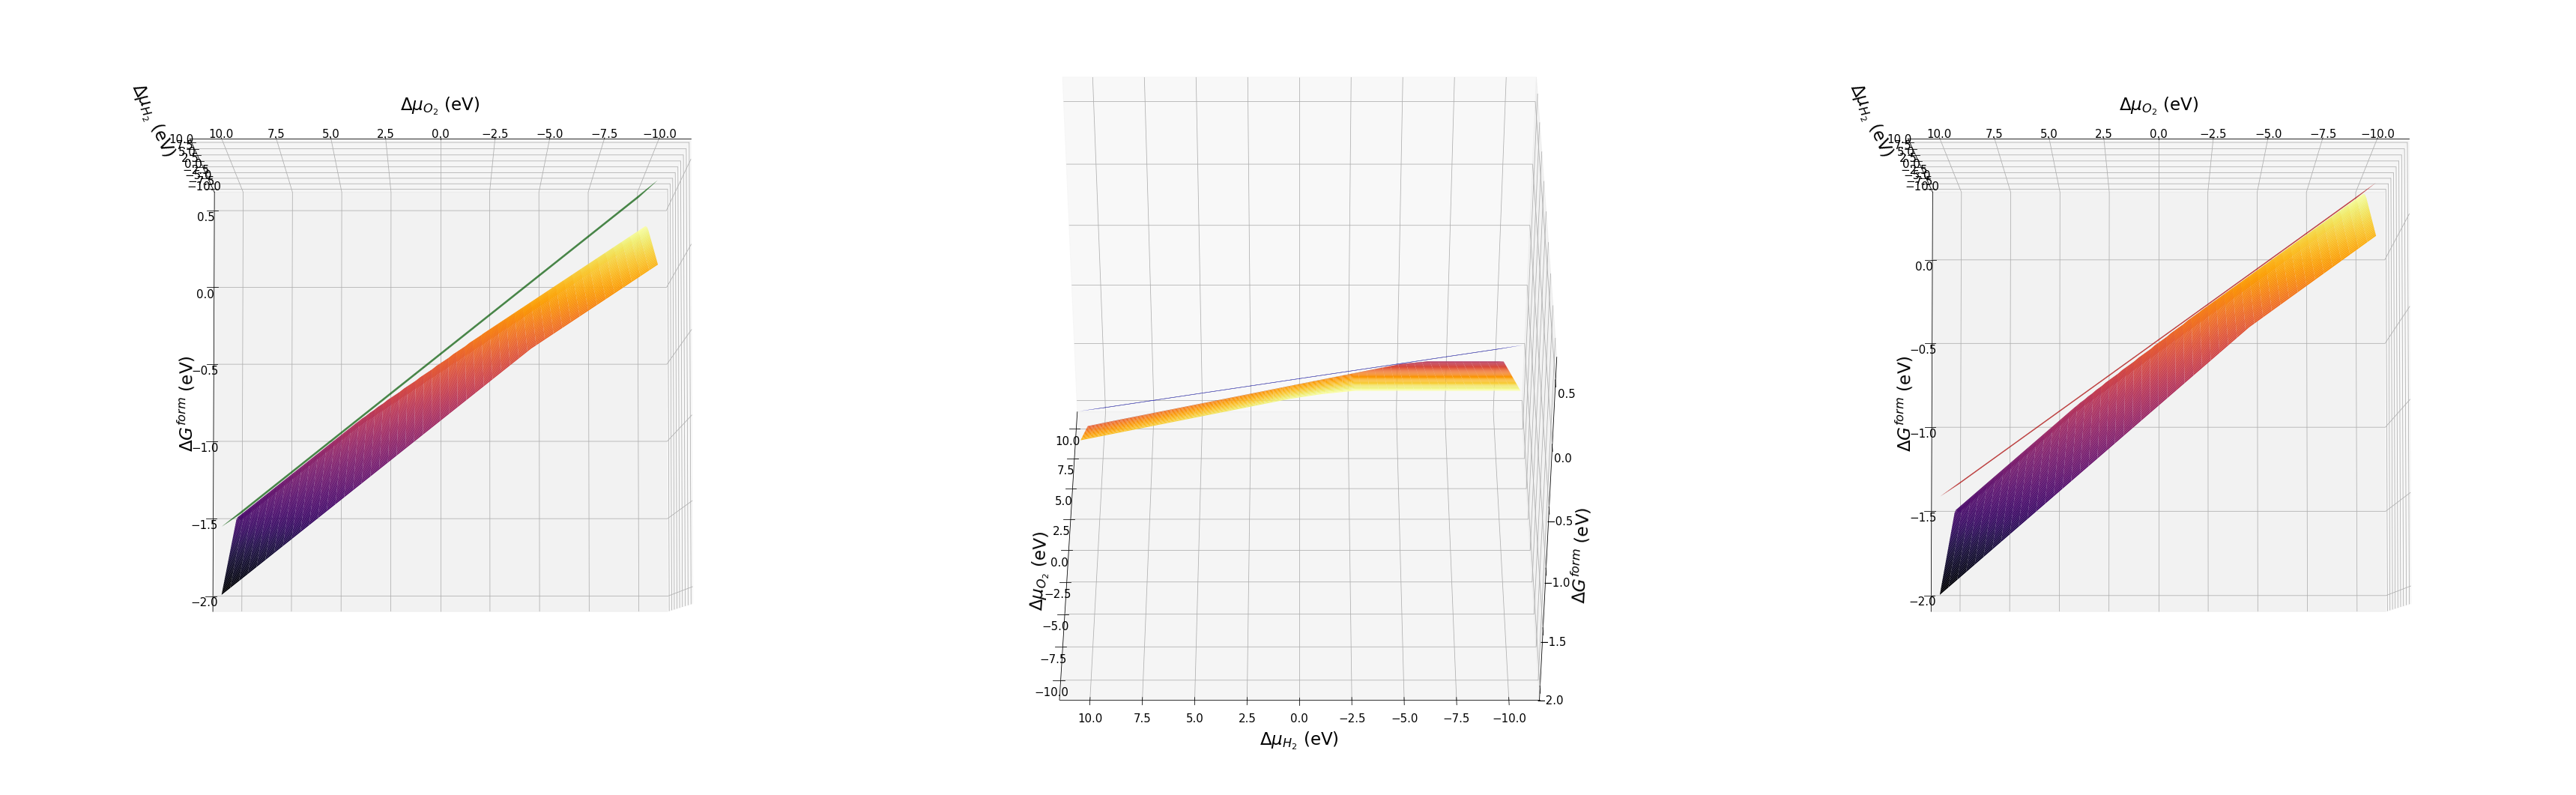

In [ ]:
# Generation of delG Data
Gmin_min = min_deltaG(delta_muO2, delta_muH2) # get continuous Gmin
G_octa_1h = deltaG_form_mu_H2(E_octa_1h,  delta_muO2, delta_muH2, 4, 12, 1)
G_octa_3h = deltaG_form_mu_H2(E_octa_3h,  delta_muO2, delta_muH2, 4, 12, 3)
G_tetra_1h = deltaG_form_mu_H2(E_tetra_1h, delta_muO2, delta_muH2, 4, 10, 1)

# Set overall size of figure
fig = plt.figure(figsize=(48,15))
ax1 = fig.add_subplot(131, projection='3d')
ax1.view_init(-4, 90)
surf1 = ax1.plot_surface(delta_muO2, delta_muH2, Gmin_min, cmap='inferno')
surf2 = ax1.plot_surface(delta_muO2, delta_muH2, G_octa_1h, color='g')

ax2 = fig.add_subplot(132, projection='3d')
ax2.view_init(40, 180)
surf1 = ax2.plot_surface(delta_muO2, delta_muH2, Gmin_min, cmap='inferno')
surf2 = ax2.plot_surface(delta_muO2, delta_muH2, G_octa_3h, color='b', alpha=1)

ax3 = fig.add_subplot(133, projection='3d')
ax3.view_init(-4, 90)
surf1 = ax3.plot_surface(delta_muO2, delta_muH2, Gmin_min, cmap='inferno')
surf2 = ax3.plot_surface(delta_muO2, delta_muH2, G_tetra_1h, color='r')

for axes in [ax1, ax2, ax3]:
  axes.set_xlabel('$\Delta \mu_{O_2}$ (eV)', size=23, labelpad=15)
  axes.set_ylabel('$\Delta \mu_{H_2}$ (eV)', size=23, labelpad=40)
  axes.set_zlabel('$\Delta G^{form}$ (eV)', size=23, labelpad=15)

ax2.set_ylabel('$\Delta \mu_{H_2}$ (eV)', size=23, labelpad=15)

fig.tight_layout()
plt.show()



It was confirmed that *octa_1h*, *octa_3h*, and tetra_1h models were not seen in the phase diagram since these are above the minimum free energy surface for all the range of $\mu_{O_2}$ and $\mu_{H_2}$.

## **4. 4. Discretized Ten-phased Diagram**

In [ ]:
delta_muO2 = np.linspace(-10,10,1000)
delta_muH2 = np.linspace(-10,10,1000)

delta_muO2, delta_muH2 = np.meshgrid(delta_muO2, delta_muH2)

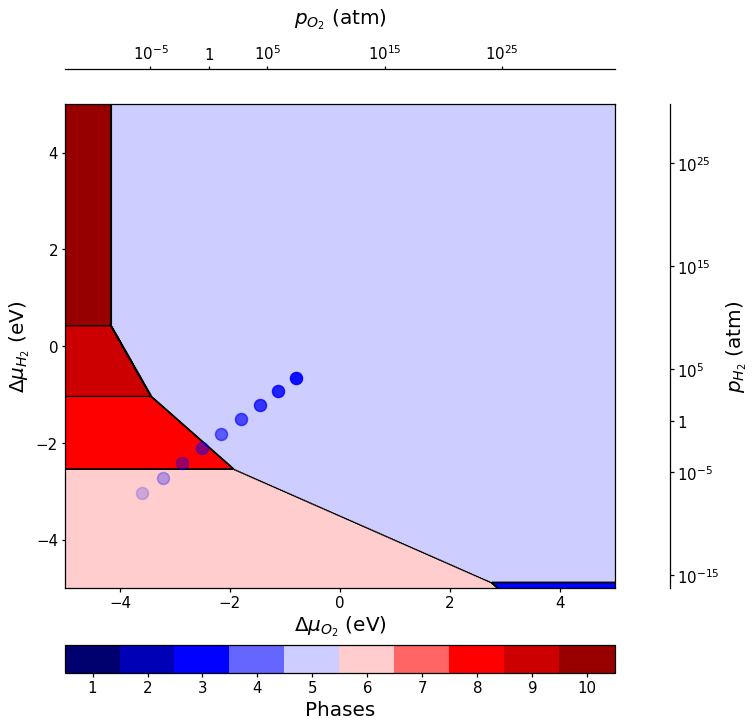

In [ ]:
plt.rcParams["font.family"] = "sans-serif"
borderwidth = 1.25
linewidth = 1.25

# Set overall size of figure
fig = plt.figure(figsize=(10.6,10.5))
# ax = fig.gca(projection='3d')
ax = fig.add_subplot(111)
ax.set_xlim(left=-5.0, right=5.0)
ax.set_ylim(bottom=-5.0, top=5.0)

Gmin_labeled = labeled_deltaG(delta_muO2, delta_muH2) # get labeled Gmin
Gmin_min = min_deltaG(delta_muO2, delta_muH2) # get continuous Gmin

# plt.imshow(Gmin, interpolation='gaussian')

plane1 = ax.contourf(delta_muO2, delta_muH2, Gmin_labeled,
                    cmap="seismic", levels=[0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5, 8.5, 9.5, 10.5],
                    alpha=1,
                    antialiased=False)
''' Many Color Maps:
ValueError: 'io' is not a valid value for name; supported values are 'Accent',
 'Accent_r', 'Blues', 'Blues_r', 'BrBG', 'BrBG_r', 'BuGn', 'BuGn_r', 'BuPu',
  'BuPu_r', 'CMRmap', 'CMRmap_r', 'Dark2', 'Dark2_r', 'GnBu', 'GnBu_r',
   'Greens', 'Greens_r', 'Greys', 'Greys_r', 'OrRd', 'OrRd_r', 'Oranges',
    'Oranges_r', 'PRGn', 'PRGn_r', 'Paired', 'Paired_r', 'Pastel1', 'Pastel1_r',
     'Pastel2', 'Pastel2_r', 'PiYG', 'PiYG_r', 'PuBu', 'PuBuGn', 'PuBuGn_r',
      'PuBu_r', 'PuOr', 'PuOr_r', 'PuRd', 'PuRd_r', 'Purples', 'Purples_r',
       'RdBu', 'RdBu_r', 'RdGy', 'RdGy_r', 'RdPu', 'RdPu_r', 'RdYlBu',
       'RdYlBu_r', 'RdYlGn', 'RdYlGn_r', 'Reds', 'Reds_r', 'Set1', 'Set1_r',
       'Set2', 'Set2_r', 'Set3', 'Set3_r', 'Spectral', 'Spectral_r', 'Wistia',
        'Wistia_r', 'YlGn', 'YlGnBu', 'YlGnBu_r', 'YlGn_r', 'YlOrBr', 'YlOrBr_r'
        , 'YlOrRd', 'YlOrRd_r', 'afmhot', 'afmhot_r', 'autumn', 'autumn_r',
         'binary', 'binary_r', 'bone', 'bone_r', 'brg', 'brg_r', 'bwr', 'bwr_r'
         , 'cividis', 'cividis_r', 'cool', 'cool_r', 'coolwarm', 'coolwarm_r'
         , 'copper', 'copper_r', 'cubehelix', 'cubehelix_r', 'flag', 'flag_r',
          'gist_earth', 'gist_earth_r', 'gist_gray', 'gist_gray_r', 'gist_heat',
           'gist_heat_r', 'gist_ncar', 'gist_ncar_r', 'gist_rainbow',
            'gist_rainbow_r', 'gist_stern', 'gist_stern_r', 'gist_yarg',
            'gist_yarg_r', 'gnuplot', 'gnuplot2', 'gnuplot2_r', 'gnuplot_r',
             'gray', 'gray_r', 'hot', 'hot_r', 'hsv', 'hsv_r', 'inferno',
              'inferno_r', 'jet', 'jet_r', 'magma', 'magma_r', 'nipy_spectral',
               'nipy_spectral_r', 'ocean', 'ocean...
'''
# plane2 = ax.contourf(delta_muO2, delta_muH2, Gmin_min,
#                     cmap="magma", alpha=0, levels=200,
#                     antialiased=False,)

line1 = ax.contour(delta_muO2, delta_muH2, Gmin_labeled, linestyles=['solid',],
                  levels=[.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5, 8.5, 9.5],linewidths=linewidth, colors=['k',])
line2 = ax.contour(delta_muO2, delta_muH2, Gmin_min, linestyles=['dashed',],
                  levels=[0,],linewidths=1.5, colors=['k',])
ax.clabel(line2, line2.levels, inline=True, fmt='$\Delta G^{form}_{min}$ = %1.1f eV',
          fontsize=15, inline_spacing=15, manual=[(-7,-6.4),])

for temp in [1073, 973, 873, 773, 673, 573, 473, 373, 273]:
  point = plt.plot(delta_mu_O2(temp,0.20946e-5*po),
                   delta_mu_H2(temp,1e-7*po),
                   'bo-', markersize=12, mew=1.5, alpha=((1273-temp)/1073))
  # position of common experimental condition

ax.set_xlabel('$\Delta \mu_{O_2}$ (eV)', size=20)
ax.set_ylabel('$\Delta \mu_{H_2}$ (eV)', size=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

for axis in ['top','bottom','left','right']:
  ax.spines[axis].set_linewidth(borderwidth)

ax.xaxis.set_tick_params(width=borderwidth)
ax.yaxis.set_tick_params(width=borderwidth)

# Second x axis
# ax2 = ax.twiny() # xaxis for p@773K
ax3 = ax.twiny() # xaxis for p@1073K

p_values_773 = [1e-20, 1e-10, 1, 1e10, 1e20, 1e30] # labels of the xticklabels: the position in the new x-axis
p_labels_773 = ['$10^{-20}$', '$10^{-10}$', '$1$', '$10^{10}$', '$10^{20}$', '$10^{30}$']
# k2degc = lambda t: t-273.15 # convert function: from Kelvin to Degree Celsius
# newpos   = [k2degc(t) for t in newlabel]   # position of the xticklabels in the old x-axis
newpos_at_773 = [delta_mu_O2(773, p) for p in p_values_773]
ax2.set_xticks(newpos_at_773)
ax2.set_xticklabels(p_labels_773)
ax2.xaxis.set_ticks_position('top') # set the position of the second x-axis to bottom
ax2.xaxis.set_label_position('top') # set the position of the second x-axis to bottom
# ax2.set_xlabel('Temperature [K]')
ax2.set_xlim(ax.get_xlim())
# ax2.spines['top'].set_position(('outward', 66))
ax2.spines['top'].set_linewidth(borderwidth)
ax2.tick_params(labelsize=15, width=borderwidth)

p_values_1073 = [1e-15, 1e-5, 1, 1e5, 1e15, 1e25] # labels of the xticklabels: the position in the new x-axis
p_labels_1073 = ['$10^{-15}$', '$10^{-5}$', '$1$', '$10^{5}$', '$10^{15}$', '$10^{25}$']
newpos_at_1073 = [delta_mu_O2(1073, p) for p in p_values_1073]
ax3.set_xticks(newpos_at_1073)
ax3.set_xticklabels(p_labels_1073)
ax3.xaxis.set_ticks_position('top') # set the position of the second x-axis to bottom
ax3.xaxis.set_label_position('top') # set the position of the second x-axis to bottom
ax3.set_xlabel('$p_{O_2}$ (atm)', size=20, labelpad=20)
ax3.set_xlim(ax.get_xlim())
ax3.spines['top'].set_position(('outward', 35))
ax3.spines['top'].set_linewidth(borderwidth)
ax3.tick_params(labelsize=15, width=borderwidth)

# Second y axis
# ax4 = ax.twinx() # xaxis for p@773K
ax5 = ax.twinx() # xaxis for p@1073K

newpos_at_773 = [delta_mu_H2(773, p) for p in p_values_773]
ax4.set_yticks(newpos_at_773)
ax4.set_yticklabels(p_labels_773)
ax4.yaxis.set_ticks_position('right') # set the position of the second x-axis to bottom
ax4.yaxis.set_label_position('right') # set the position of the second x-axis to bottom
ax4.set_ylim(ax.get_ylim())
ax4.spines['right'].set_linewidth(borderwidth)
ax4.tick_params(labelsize=15, width=borderwidth)

newpos_at_1073 = [delta_mu_H2(1073, p) for p in p_values_1073]
ax5.set_yticks(newpos_at_1073)
ax5.set_yticklabels(p_labels_1073)
ax5.yaxis.set_ticks_position('right') # set the position of the second x-axis to bottom
ax5.yaxis.set_label_position('right') # set the position of the second x-axis to bottom
ax5.set_ylabel('$p_{H_2}$ (atm)', size=20, labelpad=5)
ax5.set_ylim(ax.get_ylim())
ax5.spines['right'].set_position(('outward', 55))
ax5.spines['right'].set_linewidth(borderwidth)
ax5.tick_params(labelsize=15, width=borderwidth)

# # Texts
# plt.text(4.95, 4.75,'773 K', fontsize=15, rotation=-30)
# plt.text(5.15, 5.15,'1073 K', fontsize=15, rotation=-30)

# Colorbar
cbar = fig.colorbar(plane1, orientation='horizontal',
                    ticks=np.linspace(0.0,10.0,11),
                    pad=0.09)
cbar.outline.set_linewidth(borderwidth)
cbar.set_label('Phases', fontsize=20, labelpad=5)
cbar.ax.tick_params(labelsize=15, width=borderwidth)
fig.tight_layout()
plt.show()

## **4. 5. Diagrams as a Function of T, p**

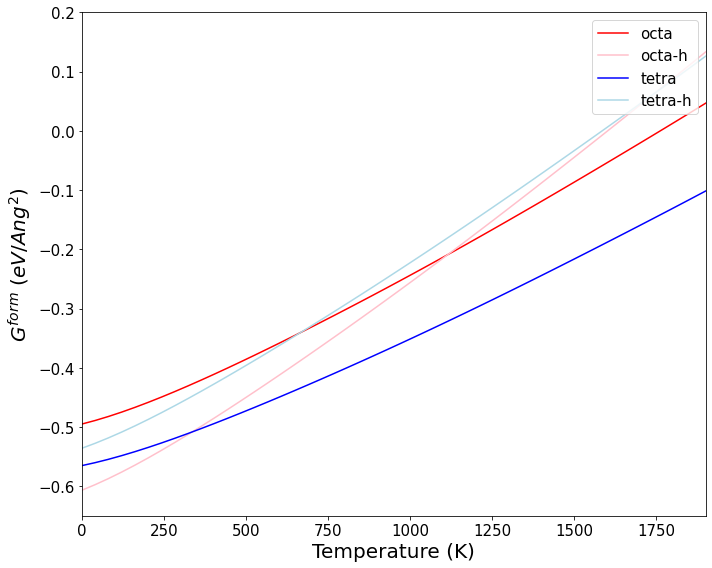

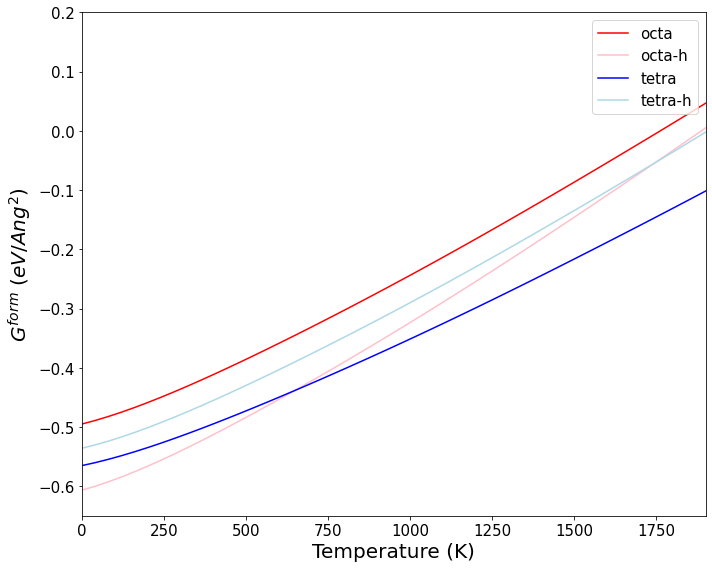

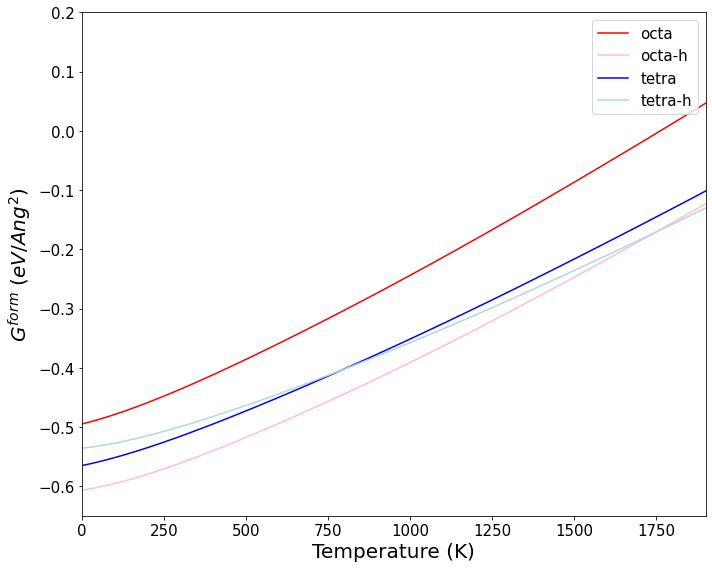

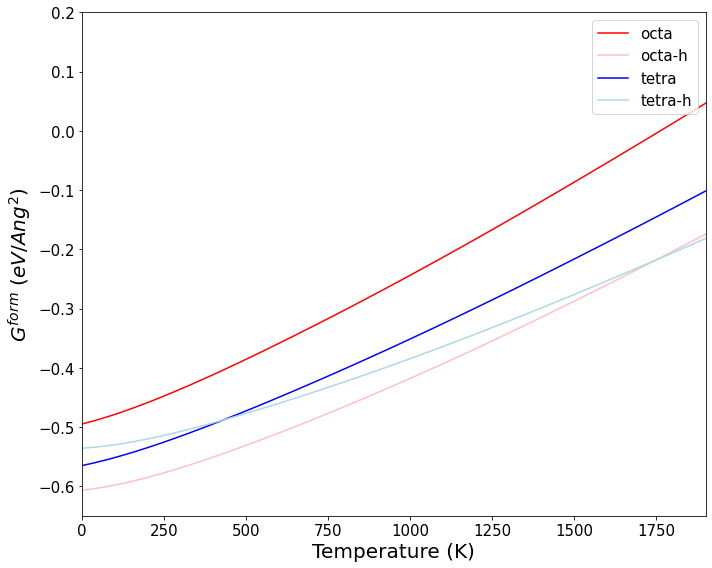

In [ ]:
#T, p_H2O = np.meshgrid(T, p_H2O)
# delta_mu_O2 = np.linspace(-20,10,200)
# delta_mu_H2O = np.linspace(-10,20,200)

# pO2 = np.linspace(1e-14,1e10,50)
# pH2O = np.linspace(1e-14,1e10,100)
# pV = np.linspace(1e-14,1e10,50)
T = np.linspace(0,4000,100) # K


# ax = fig.gca(projection='3d')
# ax = fig.add_subplot(111)

# delta_mu_O2, delta_mu_H2O = np.meshgrid(delta_mu_O2, delta_mu_H2O)
# plane = ax.contourf(delta_mu_O2, delta_mu_H2O, deltaG_form(E_octa, 0, delta_mu_O2, delta_mu_H2O, 4,12,0),
#                     levels = ut.get_levels(deltaG_form(E_octa, 0, delta_mu_O2, delta_mu_H2O, 4,12,0)),
#                     cmap="viridis")
# plane = ax.contourf(delta_mu_O2, delta_mu_H2O, deltaG_form(E_octa_h, 0, delta_mu_O2, delta_mu_H2O, 4,12,4),
#                     levels = ut.get_levels(deltaG_form(E_octa_h, 0, delta_mu_O2, delta_mu_H2O, 4,12,4)),
                    # cmap="viridis")
# plane = ax.contourf(delta_mu_O2, delta_mu_H2O, deltaG_form(E_tetra, 0, delta_mu_O2, delta_mu_H2O, 4,10,0),
#                     levels = ut.get_levels(deltaG_form(E_tetra, 0, delta_mu_O2, delta_mu_H2O, 4,10,0)),
#                     cmap="viridis")
# plane = ax.contourf(delta_mu_O2, delta_mu_H2O, deltaG_form(E_tetra_h, 0, delta_mu_O2, delta_mu_H2O, 4,10,4),
#                     levels = ut.get_levels(deltaG_form(E_tetra_h, 0, delta_mu_O2, delta_mu_H2O, 4,10,4)),
#                     cmap="viridis")

# T, pH2O = np.meshgrid(T, pH2O)
# plane = ax.contourf(T, pH2O, deltaG_form(E_octa,  T, po,po,pH2O, 4,12,0),
#                     levels = ut.get_levels(deltaG_form(E_octa,  T, po,po,pH2O, 4,12,0)),
#                     cmap="viridis")
# plane = ax.contourf(T, pH2O, deltaG_form(E_octa_h,T, po,po,pH2O, 4,12,4),
#                     levels = ut.get_levels(deltaG_form(E_octa_h,T, po,po,pH2O, 4,12,4)),
#                     cmap="viridis")
# plane = ax.contourf(T, pH2O, deltaG_form(E_tetra, T, po,po,pH2O, 4,10,0),
#                     levels = ut.get_levels(deltaG_form(E_tetra, T, po,po,pH2O, 4,10,0)),
#                     cmap="viridis")
# plane = ax.contourf(T, pH2O, deltaG_form(E_tetra_h, T, po,po,pH2O, 4,10,4),
#                     levels = ut.get_levels(deltaG_form(E_tetra_h, T, po,po,pH2O, 4,10,4)),
#                     cmap="viridis")

for pH2O in [1e-10, 1, 1e10, 1e14]:
  fig = plt.figure(figsize=(10,8))
  ax = fig.add_subplot(111)
  plt.xticks(fontsize=15)
  plt.yticks(fontsize=15)

  line1 = plt.plot(T,deltaG_form(E_octa,  T, po,po,pH2O, 4,12,0),
                  label='octa', color='red')
  line2 = plt.plot(T,deltaG_form(E_octa_h,  T, po,po,pH2O, 4,12,4),
                  label='octa-h', color='pink')
  line3 = plt.plot(T,deltaG_form(E_tetra,  T, po,po,pH2O, 4,10,0),
                  label='tetra', color='blue')
  line4 = plt.plot(T,deltaG_form(E_tetra_h,  T, po,po,pH2O, 4,10,4),
                  label='tetra-h', color='lightblue')

  # ax.set_xlabel('T (K)')
  # ax.set_ylabel('$p_H2O$')
  # ax.set_xlabel('$\Delta \mu_{O_2}$ (eV)', size=20)
  # ax.set_ylabel('$\Delta \mu_{H_2O}$ (eV)', size=20)
  # plt.xlabel('$p_{H_2O}$ (atm)', size=20)
  plt.xlabel('Temperature (K)', size=20)
  plt.ylabel('$G^{form}$ $(eV/Ang^2)$', size=20)
  plt.xlim(0,1900)
  plt.ylim(-0.65,0.2)

  # phases = np.array(['octa', 'octa-h', 'tetra', 'tetra-h'])
  # ticky = ut.get_ticks(phases)
  # cbar = fig.colorbar(plane, ticks=ticky, pad=0.1)
  # cbar = fig.colorbar(plane, pad=0.1)
  # cbar.ax.set_yticklabels(phases)
  plt.legend(loc='upper right', fontsize=15)
  fig.tight_layout()
  plt.show()

## **4.6. Ten-phased Diagram based on $H_2O$ partial pressures**

In [ ]:
delta_muO2 = np.linspace(-10,10,1000)
delta_muH2O = np.linspace(-10,10,1000)

delta_muO2, delta_muH2O = np.meshgrid(delta_muO2, delta_muH2O)

In [ ]:
# Definition of functions of minimum free energy surface
def labeled_deltaG(delta_muO2, delta_muH2O):
  G1 = deltaG_form_mu_H2O(E_octa,     delta_muO2, delta_muH2O, 4, 12, 0)
  G2 = deltaG_form_mu_H2O(E_octa_1h,  delta_muO2, delta_muH2O, 4, 12, 1)
  G3 = deltaG_form_mu_H2O(E_octa_2h,  delta_muO2, delta_muH2O, 4, 12, 2)
  G4 = deltaG_form_mu_H2O(E_octa_3h,  delta_muO2, delta_muH2O, 4, 12, 3)
  G5 = deltaG_form_mu_H2O(E_octa_h,   delta_muO2, delta_muH2O, 4, 12, 4) # octa_4h
  G6 = deltaG_form_mu_H2O(E_tetra,    delta_muO2, delta_muH2O, 4, 10, 0)
  G7 = deltaG_form_mu_H2O(E_tetra_1h, delta_muO2, delta_muH2O, 4, 10, 1)
  G8 = deltaG_form_mu_H2O(E_tetra_2h, delta_muO2, delta_muH2O, 4, 10, 2)
  G9 = deltaG_form_mu_H2O(E_tetra_3h, delta_muO2, delta_muH2O, 4, 10, 3)
  G10= deltaG_form_mu_H2O(E_tetra_h,  delta_muO2, delta_muH2O, 4, 10, 4) # tetra_4h

  Gmin = np.minimum(G1,   G2) # element-wise minimum of two arrays
  Gmin = np.minimum(Gmin, G3)
  Gmin = np.minimum(Gmin, G4)
  Gmin = np.minimum(Gmin, G5)
  Gmin = np.minimum(Gmin, G6)
  Gmin = np.minimum(Gmin, G7)
  Gmin = np.minimum(Gmin, G8)
  Gmin = np.minimum(Gmin, G9)
  Gmin = np.minimum(Gmin, G10)

  for i in range(len(delta_muO2)):
    for j in range(len(delta_muH2O)):
      if Gmin[i][j] == G1[i][j]:
        Gmin[i][j] = 1
      elif Gmin[i][j] == G2[i][j]:
        Gmin[i][j] = 2
      elif Gmin[i][j] == G3[i][j]:
        Gmin[i][j] = 3
      elif Gmin[i][j] == G4[i][j]:
        Gmin[i][j] = 4
      elif Gmin[i][j] == G5[i][j]:
        Gmin[i][j] = 5
      elif Gmin[i][j] == G6[i][j]:
        Gmin[i][j] = 6
      elif Gmin[i][j] == G7[i][j]:
        Gmin[i][j] = 7
      elif Gmin[i][j] == G8[i][j]:
        Gmin[i][j] = 8
      elif Gmin[i][j] == G9[i][j]:
        Gmin[i][j] = 9
      elif Gmin[i][j] == G10[i][j]:
        Gmin[i][j] = 10
      else:
        print("not matched!")

  return Gmin

def min_deltaG(delta_muO2, delta_muH2O):
  G1 = deltaG_form_mu_H2O(E_octa,     delta_muO2, delta_muH2O, 4, 12, 0)
  G2 = deltaG_form_mu_H2O(E_octa_1h,  delta_muO2, delta_muH2O, 4, 12, 1)
  G3 = deltaG_form_mu_H2O(E_octa_2h,  delta_muO2, delta_muH2O, 4, 12, 2)
  G4 = deltaG_form_mu_H2O(E_octa_3h,  delta_muO2, delta_muH2O, 4, 12, 3)
  G5 = deltaG_form_mu_H2O(E_octa_h,   delta_muO2, delta_muH2O, 4, 12, 4) # octa_4h
  G6 = deltaG_form_mu_H2O(E_tetra,    delta_muO2, delta_muH2O, 4, 10, 0)
  G7 = deltaG_form_mu_H2O(E_tetra_1h, delta_muO2, delta_muH2O, 4, 10, 1)
  G8 = deltaG_form_mu_H2O(E_tetra_2h, delta_muO2, delta_muH2O, 4, 10, 2)
  G9 = deltaG_form_mu_H2O(E_tetra_3h, delta_muO2, delta_muH2O, 4, 10, 3)
  G10= deltaG_form_mu_H2O(E_tetra_h,  delta_muO2, delta_muH2O, 4, 10, 4) # tetra_4h

  Gmin = np.minimum(G1,   G2) # element-wise minimum of two arrays
  Gmin = np.minimum(Gmin, G3)
  Gmin = np.minimum(Gmin, G4)
  Gmin = np.minimum(Gmin, G5)
  Gmin = np.minimum(Gmin, G6)
  Gmin = np.minimum(Gmin, G7)
  Gmin = np.minimum(Gmin, G8)
  Gmin = np.minimum(Gmin, G9)
  Gmin = np.minimum(Gmin, G10)

  return Gmin

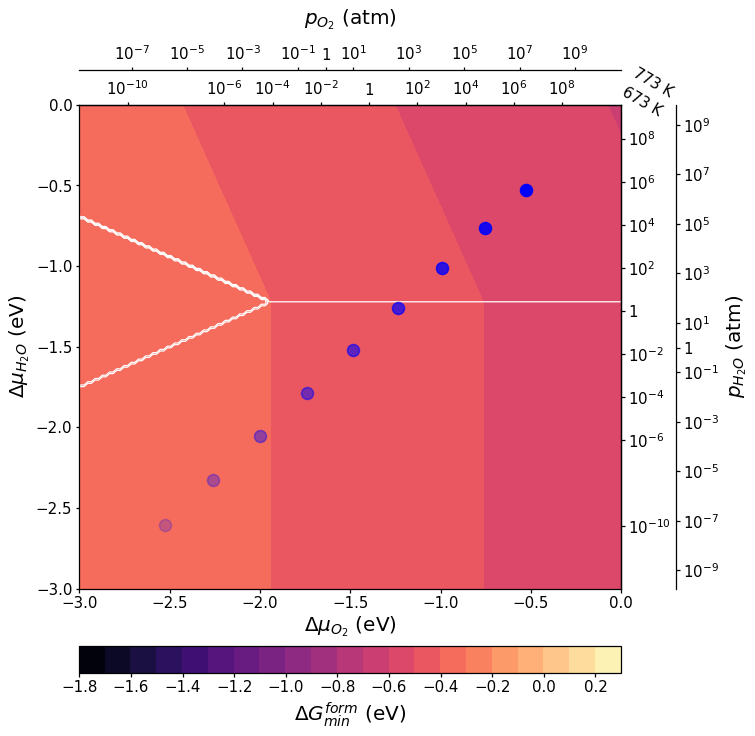

In [ ]:
plt.rcParams["font.family"] = "sans-serif"
borderwidth = 1.25
linewidth = 1.25

# Set overall size of figure
fig = plt.figure(figsize=(10.6,10.5))
# ax = fig.gca(projection='3d')
ax = fig.add_subplot(111)
ax.set_xlim(left=-3.0, right=0)
ax.set_ylim(bottom=-3.0, top=0)

# Generation of delG Data
Gmin_labeled = labeled_deltaG(delta_muO2, delta_muH2O) # get labeled Gmin
Gmin_min = min_deltaG(delta_muO2, delta_muH2O) # get continuous Gmin

# plt.imshow(Gmin, interpolation='gaussian')

# plane1 = ax.contourf(delta_muO2, delta_muH2, Gmin_labeled,
#                     cmap="ocean", levels=[0, 0.5, 1.5, 2.5, 3.5, 4.5],
#                     alpha=1,
#                     antialiased=False)
''' Many Color Maps:
ValueError: 'io' is not a valid value for name; supported values are 'Accent',
 'Accent_r', 'Blues', 'Blues_r', 'BrBG', 'BrBG_r', 'BuGn', 'BuGn_r', 'BuPu',
  'BuPu_r', 'CMRmap', 'CMRmap_r', 'Dark2', 'Dark2_r', 'GnBu', 'GnBu_r',
   'Greens', 'Greens_r', 'Greys', 'Greys_r', 'OrRd', 'OrRd_r', 'Oranges',
    'Oranges_r', 'PRGn', 'PRGn_r', 'Paired', 'Paired_r', 'Pastel1', 'Pastel1_r',
     'Pastel2', 'Pastel2_r', 'PiYG', 'PiYG_r', 'PuBu', 'PuBuGn', 'PuBuGn_r',
      'PuBu_r', 'PuOr', 'PuOr_r', 'PuRd', 'PuRd_r', 'Purples', 'Purples_r',
       'RdBu', 'RdBu_r', 'RdGy', 'RdGy_r', 'RdPu', 'RdPu_r', 'RdYlBu',
       'RdYlBu_r', 'RdYlGn', 'RdYlGn_r', 'Reds', 'Reds_r', 'Set1', 'Set1_r',
       'Set2', 'Set2_r', 'Set3', 'Set3_r', 'Spectral', 'Spectral_r', 'Wistia',
        'Wistia_r', 'YlGn', 'YlGnBu', 'YlGnBu_r', 'YlGn_r', 'YlOrBr', 'YlOrBr_r'
        , 'YlOrRd', 'YlOrRd_r', 'afmhot', 'afmhot_r', 'autumn', 'autumn_r',
         'binary', 'binary_r', 'bone', 'bone_r', 'brg', 'brg_r', 'bwr', 'bwr_r'
         , 'cividis', 'cividis_r', 'cool', 'cool_r', 'coolwarm', 'coolwarm_r'
         , 'copper', 'copper_r', 'cubehelix', 'cubehelix_r', 'flag', 'flag_r',
          'gist_earth', 'gist_earth_r', 'gist_gray', 'gist_gray_r', 'gist_heat',
           'gist_heat_r', 'gist_ncar', 'gist_ncar_r', 'gist_rainbow',
            'gist_rainbow_r', 'gist_stern', 'gist_stern_r', 'gist_yarg',
            'gist_yarg_r', 'gnuplot', 'gnuplot2', 'gnuplot2_r', 'gnuplot_r',
             'gray', 'gray_r', 'hot', 'hot_r', 'hsv', 'hsv_r', 'inferno',
              'inferno_r', 'jet', 'jet_r', 'magma', 'magma_r', 'nipy_spectral',
               'nipy_spectral_r', 'ocean', 'ocean...
'''
# Labeled minimum surface of delG
plane2 = ax.contourf(delta_muO2, delta_muH2O, Gmin_min,
                    cmap="magma", alpha=1.0, levels=20,
                    antialiased=False,)

# Phase boundaries
line1 = ax.contour(delta_muO2, delta_muH2O, Gmin_labeled, linestyles=['solid',],
                  levels=[0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5, 8.5, 9.5, 10.5],
                  linewidths=linewidth, colors=['w',])

# Contour line for delG = 0
line2 = ax.contour(delta_muO2, delta_muH2O, Gmin_min, linestyles=['dashed',],
                  levels=[0,],linewidths=1.5, colors=['k',])
ax.clabel(line2, line2.levels, inline=True, fmt='$\Delta G^{form}_{min}$ = %1.1f eV',
          fontsize=15, inline_spacing=15, manual=[(-7,-6.4),])

# Temperature trajectory
for temp in [1073, 973, 873, 773, 673, 573, 473, 373, 273]:
  point = plt.plot(delta_mu_O2(temp,0.20946*po),
                   delta_mu_H2O(temp,1.5e-2*po),
                   'bo-', markersize=12, mew=1.5, alpha=((1273-temp)/1000))
  # position of common experimental condition

# Plot labels
ax.set_xlabel('$\Delta \mu_{O_2}$ (eV)', size=20)
ax.set_ylabel('$\Delta \mu_{H_2O}$ (eV)', size=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

for axis in ['top','bottom','left','right']:
  ax.spines[axis].set_linewidth(borderwidth)

ax.xaxis.set_tick_params(width=borderwidth)
ax.yaxis.set_tick_params(width=borderwidth)

# Second x axis
ax2 = ax.twiny() # xaxis for p@673K
ax3 = ax.twiny() # xaxis for p@773K

p_values_673 = [1e-14, 1e-10, 1e-6, 1e-4, 1e-2, 1, 1e2, 1e4, 1e6, 1e8] # labels of the xticklabels: the position in the new x-axis
p_labels_673 = ['$10^{-14}$', '$10^{-10}$', '$10^{-6}$', '$10^{-4}$', '$10^{-2}$', '$1$', '$10^{2}$', '$10^{4}$', '$10^{6}$', '$10^{8}$']
# k2degc = lambda t: t-273.15 # convert function: from Kelvin to Degree Celsius
# newpos   = [k2degc(t) for t in newlabel]   # position of the xticklabels in the old x-axis
newpos_at_673 = [delta_mu_O2(673, p) for p in p_values_673]
ax2.set_xticks(newpos_at_673)
ax2.set_xticklabels(p_labels_673)
ax2.xaxis.set_ticks_position('top') # set the position of the second x-axis to bottom
ax2.xaxis.set_label_position('top') # set the position of the second x-axis to bottom
# ax2.set_xlabel('Temperature [K]')
ax2.set_xlim(ax.get_xlim())
# ax2.spines['top'].set_position(('outward', 66))
ax2.spines['top'].set_linewidth(borderwidth)
ax2.tick_params(labelsize=15, width=borderwidth)

p_values_773 = [1e-13, 1e-11, 1e-9, 1e-7, 1e-5, 1e-3, 1e-1, 1, 1e1, 1e3, 1e5, 1e7, 1e9, 1e12] # labels of the xticklabels: the position in the new x-axis
p_labels_773 = ['$10^{-13}$', '$10^{-11}$', '$10^{-9}$', '$10^{-7}$', '$10^{-5}$', '$10^{-3}$', '$10^{-1}$', '$1$', '$10^{1}$', '$10^{3}$', '$10^{5}$', '$10^{7}$', '$10^{9}$', '$10^{12}$']
newpos_at_773 = [delta_mu_O2(773, p) for p in p_values_773]
ax3.set_xticks(newpos_at_773)
ax3.set_xticklabels(p_labels_773)
ax3.xaxis.set_ticks_position('top') # set the position of the second x-axis to bottom
ax3.xaxis.set_label_position('top') # set the position of the second x-axis to bottom
ax3.set_xlabel('$p_{O_2}$ (atm)', size=20, labelpad=20)
ax3.set_xlim(ax.get_xlim())
ax3.spines['top'].set_position(('outward', 35))
ax3.spines['top'].set_linewidth(borderwidth)
ax3.tick_params(labelsize=15, width=borderwidth)

# Second y axis
ax4 = ax.twinx() # xaxis for p@673K
ax5 = ax.twinx() # xaxis for p@773K

newpos_at_673 = [delta_mu_H2O(673, p) for p in p_values_673]
ax4.set_yticks(newpos_at_673)
ax4.set_yticklabels(p_labels_673)
ax4.yaxis.set_ticks_position('right') # set the position of the second x-axis to bottom
ax4.yaxis.set_label_position('right') # set the position of the second x-axis to bottom
ax4.set_ylim(ax.get_ylim())
ax4.spines['right'].set_linewidth(borderwidth)
ax4.tick_params(labelsize=15, width=borderwidth)

newpos_at_773 = [delta_mu_H2O(773, p) for p in p_values_773]
ax5.set_yticks(newpos_at_773)
ax5.set_yticklabels(p_labels_773)
ax5.yaxis.set_ticks_position('right') # set the position of the second x-axis to bottom
ax5.yaxis.set_label_position('right') # set the position of the second x-axis to bottom
ax5.set_ylabel('$p_{H_2O}$ (atm)', size=20, labelpad=5)
ax5.set_ylim(ax.get_ylim())
ax5.spines['right'].set_position(('outward', 55))
ax5.spines['right'].set_linewidth(borderwidth)
ax5.tick_params(labelsize=15, width=borderwidth)

# Texts
plt.text(-0.01, -0.07,'673 K', fontsize=15, rotation=-30)
plt.text(0.05, 0.05,'773 K', fontsize=15, rotation=-30)

# Colorbar
cbar = fig.colorbar(plane2, orientation='horizontal',
                    ticks=np.linspace(-2.0,0.2,12),
                    pad=0.09)
cbar.outline.set_linewidth(borderwidth)
cbar.set_label('$\Delta G^{form}_{min}$ (eV)', fontsize=20, labelpad=5)
cbar.ax.tick_params(labelsize=15, width=borderwidth)
fig.tight_layout()
plt.show()

### **4. 6. 1. Checking Where 1h Models are Relative to Min Surface**

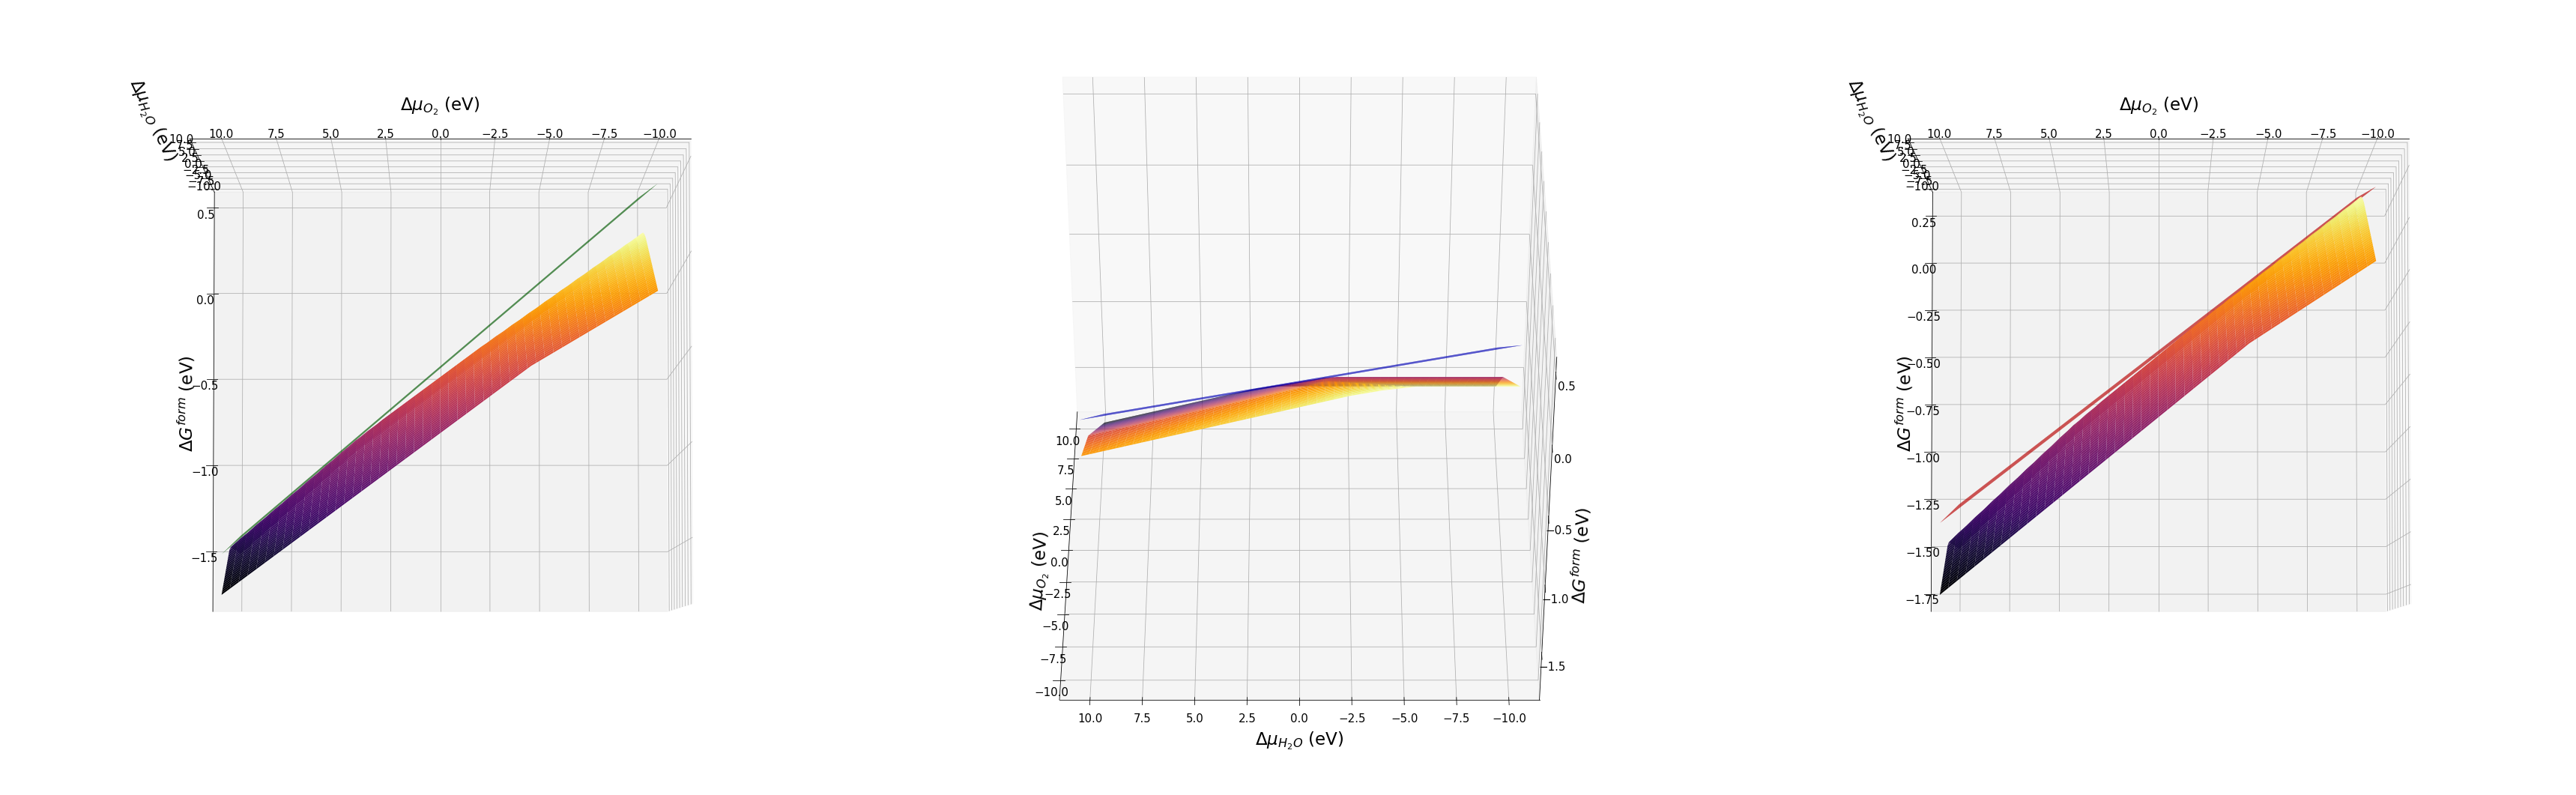

In [ ]:
plt.rcParams["font.family"] = "sans-serif"
plt.rcParams["font.size"] = 15
borderwidth = 1.25
linewidth = 1.2

# Generation of delG Data
Gmin_min = min_deltaG(delta_muO2, delta_muH2O) # get continuous Gmin
G_octa_1h = deltaG_form_mu_H2O(E_octa_1h,  delta_muO2, delta_muH2O, 4, 12, 1)
G_octa_3h = deltaG_form_mu_H2O(E_octa_3h,  delta_muO2, delta_muH2O, 4, 12, 3)
G_tetra_1h = deltaG_form_mu_H2O(E_tetra_1h, delta_muO2, delta_muH2O, 4, 10, 1)

# Set overall size of figure
fig = plt.figure(figsize=(48,15))
ax1 = fig.add_subplot(131, projection='3d')
ax1.view_init(-4, 90)
surf1 = ax1.plot_surface(delta_muO2, delta_muH2O, Gmin_min, cmap='inferno')
surf2 = ax1.plot_surface(delta_muO2, delta_muH2O, G_octa_1h, color='g')

ax2 = fig.add_subplot(132, projection='3d')
ax2.view_init(40, 180)
surf1 = ax2.plot_surface(delta_muO2, delta_muH2O, Gmin_min, cmap='inferno')
surf2 = ax2.plot_surface(delta_muO2, delta_muH2O, G_octa_3h, color='b', alpha=1)

ax3 = fig.add_subplot(133, projection='3d')
ax3.view_init(-4, 90)
surf1 = ax3.plot_surface(delta_muO2, delta_muH2O, Gmin_min, cmap='inferno')
surf2 = ax3.plot_surface(delta_muO2, delta_muH2O, G_tetra_1h, color='r')

for axes in [ax1, ax2, ax3]:
  axes.set_xlabel('$\Delta \mu_{O_2}$ (eV)', size=23, labelpad=15)
  axes.set_ylabel('$\Delta \mu_{H_2O}$ (eV)', size=23, labelpad=40)
  axes.set_zlabel('$\Delta G^{form}$ (eV)', size=23, labelpad=15)

ax2.set_ylabel('$\Delta \mu_{H_2O}$ (eV)', size=23, labelpad=15)

fig.tight_layout()
plt.show()



In [ ]:
delta_muO2 = np.linspace(-10,10,1000)
delta_muH2O = np.linspace(-10,10,1000)

delta_muO2, delta_muH2O = np.meshgrid(delta_muO2, delta_muH2O)

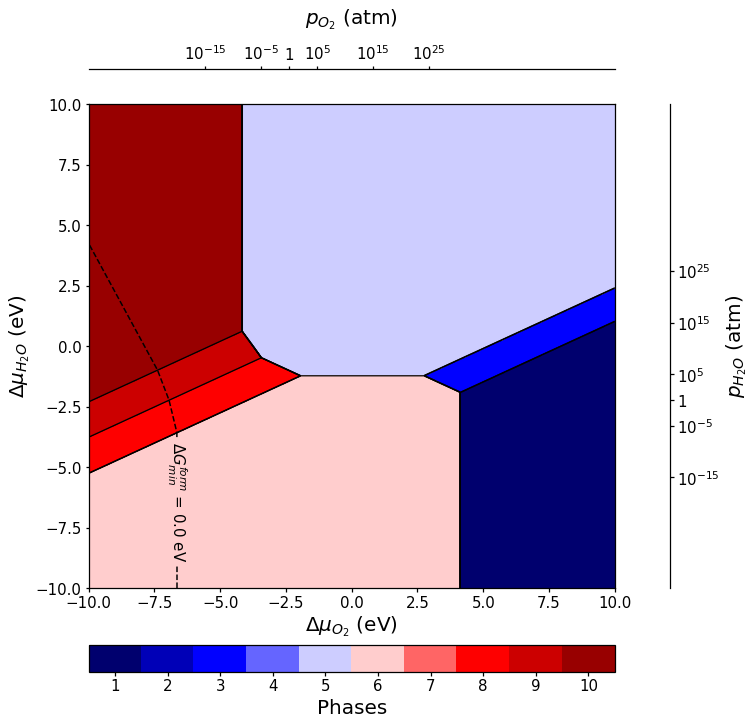

In [ ]:
plt.rcParams["font.family"] = "sans-serif"
borderwidth = 1.25
linewidth = 1.25

# Set overall size of figure
fig = plt.figure(figsize=(10.6,10.5))
# ax = fig.gca(projection='3d')
ax = fig.add_subplot(111)
# ax.set_xlim(left=-5.0, right=5.0)
# ax.set_ylim(bottom=-5.0, top=5.0)

Gmin_labeled = labeled_deltaG(delta_muO2, delta_muH2O) # get labeled Gmin
Gmin_min = min_deltaG(delta_muO2, delta_muH2O) # get continuous Gmin

# plt.imshow(Gmin, interpolation='gaussian')

plane1 = ax.contourf(delta_muO2, delta_muH2O, Gmin_labeled,
                    cmap="seismic", levels=[0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5, 8.5, 9.5, 10.5],
                    alpha=1,
                    antialiased=False)
''' Many Color Maps:
ValueError: 'io' is not a valid value for name; supported values are 'Accent',
 'Accent_r', 'Blues', 'Blues_r', 'BrBG', 'BrBG_r', 'BuGn', 'BuGn_r', 'BuPu',
  'BuPu_r', 'CMRmap', 'CMRmap_r', 'Dark2', 'Dark2_r', 'GnBu', 'GnBu_r',
   'Greens', 'Greens_r', 'Greys', 'Greys_r', 'OrRd', 'OrRd_r', 'Oranges',
    'Oranges_r', 'PRGn', 'PRGn_r', 'Paired', 'Paired_r', 'Pastel1', 'Pastel1_r',
     'Pastel2', 'Pastel2_r', 'PiYG', 'PiYG_r', 'PuBu', 'PuBuGn', 'PuBuGn_r',
      'PuBu_r', 'PuOr', 'PuOr_r', 'PuRd', 'PuRd_r', 'Purples', 'Purples_r',
       'RdBu', 'RdBu_r', 'RdGy', 'RdGy_r', 'RdPu', 'RdPu_r', 'RdYlBu',
       'RdYlBu_r', 'RdYlGn', 'RdYlGn_r', 'Reds', 'Reds_r', 'Set1', 'Set1_r',
       'Set2', 'Set2_r', 'Set3', 'Set3_r', 'Spectral', 'Spectral_r', 'Wistia',
        'Wistia_r', 'YlGn', 'YlGnBu', 'YlGnBu_r', 'YlGn_r', 'YlOrBr', 'YlOrBr_r'
        , 'YlOrRd', 'YlOrRd_r', 'afmhot', 'afmhot_r', 'autumn', 'autumn_r',
         'binary', 'binary_r', 'bone', 'bone_r', 'brg', 'brg_r', 'bwr', 'bwr_r'
         , 'cividis', 'cividis_r', 'cool', 'cool_r', 'coolwarm', 'coolwarm_r'
         , 'copper', 'copper_r', 'cubehelix', 'cubehelix_r', 'flag', 'flag_r',
          'gist_earth', 'gist_earth_r', 'gist_gray', 'gist_gray_r', 'gist_heat',
           'gist_heat_r', 'gist_ncar', 'gist_ncar_r', 'gist_rainbow',
            'gist_rainbow_r', 'gist_stern', 'gist_stern_r', 'gist_yarg',
            'gist_yarg_r', 'gnuplot', 'gnuplot2', 'gnuplot2_r', 'gnuplot_r',
             'gray', 'gray_r', 'hot', 'hot_r', 'hsv', 'hsv_r', 'inferno',
              'inferno_r', 'jet', 'jet_r', 'magma', 'magma_r', 'nipy_spectral',
               'nipy_spectral_r', 'ocean', 'ocean...
'''
plane2 = ax.contourf(delta_muO2, delta_muH2O, Gmin_min,
                    cmap="magma", alpha=0, levels=200,
                    antialiased=False,)

line1 = ax.contour(delta_muO2, delta_muH2O, Gmin_labeled, linestyles=['solid',],
                  levels=[.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5, 8.5, 9.5],linewidths=linewidth, colors=['k',])
line2 = ax.contour(delta_muO2, delta_muH2O, Gmin_min, linestyles=['dashed',],
                  levels=[0,],linewidths=1.5, colors=['k',])
ax.clabel(line2, line2.levels, inline=True, fmt='$\Delta G^{form}_{min}$ = %1.1f eV',
          fontsize=15, inline_spacing=15, manual=[(-7,-6.4),])

# for temp in [1073, 973, 873, 773, 673, 573, 473, 373, 273]:
#   point = plt.plot(delta_mu_O2(temp,0.20946e-5*po),
#                    delta_mu_H2O(temp,1e-7*po),
#                    'bo-', markersize=12, mew=1.5, alpha=((1273-temp)/1073))
  # position of common experimental condition

ax.set_xlabel('$\Delta \mu_{O_2}$ (eV)', size=20)
ax.set_ylabel('$\Delta \mu_{H_2O}$ (eV)', size=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

for axis in ['top','bottom','left','right']:
  ax.spines[axis].set_linewidth(borderwidth)

ax.xaxis.set_tick_params(width=borderwidth)
ax.yaxis.set_tick_params(width=borderwidth)

# Second x axis
# ax2 = ax.twiny() # xaxis for p@773K
ax3 = ax.twiny() # xaxis for p@1073K

p_values_773 = [1e-20, 1e-10, 1, 1e10, 1e20, 1e30] # labels of the xticklabels: the position in the new x-axis
p_labels_773 = ['$10^{-20}$', '$10^{-10}$', '$1$', '$10^{10}$', '$10^{20}$', '$10^{30}$']
# k2degc = lambda t: t-273.15 # convert function: from Kelvin to Degree Celsius
# newpos   = [k2degc(t) for t in newlabel]   # position of the xticklabels in the old x-axis
newpos_at_773 = [delta_mu_O2(773, p) for p in p_values_773]
ax2.set_xticks(newpos_at_773)
ax2.set_xticklabels(p_labels_773)
ax2.xaxis.set_ticks_position('top') # set the position of the second x-axis to bottom
ax2.xaxis.set_label_position('top') # set the position of the second x-axis to bottom
# ax2.set_xlabel('Temperature [K]')
ax2.set_xlim(ax.get_xlim())
# ax2.spines['top'].set_position(('outward', 66))
ax2.spines['top'].set_linewidth(borderwidth)
ax2.tick_params(labelsize=15, width=borderwidth)

p_values_1073 = [1e-15, 1e-5, 1, 1e5, 1e15, 1e25] # labels of the xticklabels: the position in the new x-axis
p_labels_1073 = ['$10^{-15}$', '$10^{-5}$', '$1$', '$10^{5}$', '$10^{15}$', '$10^{25}$']
newpos_at_1073 = [delta_mu_O2(1073, p) for p in p_values_1073]
ax3.set_xticks(newpos_at_1073)
ax3.set_xticklabels(p_labels_1073)
ax3.xaxis.set_ticks_position('top') # set the position of the second x-axis to bottom
ax3.xaxis.set_label_position('top') # set the position of the second x-axis to bottom
ax3.set_xlabel('$p_{O_2}$ (atm)', size=20, labelpad=20)
ax3.set_xlim(ax.get_xlim())
ax3.spines['top'].set_position(('outward', 35))
ax3.spines['top'].set_linewidth(borderwidth)
ax3.tick_params(labelsize=15, width=borderwidth)

# Second y axis
# ax4 = ax.twinx() # xaxis for p@773K
ax5 = ax.twinx() # xaxis for p@1073K

newpos_at_773 = [delta_mu_H2O(773, p) for p in p_values_773]
ax4.set_yticks(newpos_at_773)
ax4.set_yticklabels(p_labels_773)
ax4.yaxis.set_ticks_position('right') # set the position of the second x-axis to bottom
ax4.yaxis.set_label_position('right') # set the position of the second x-axis to bottom
ax4.set_ylim(ax.get_ylim())
ax4.spines['right'].set_linewidth(borderwidth)
ax4.tick_params(labelsize=15, width=borderwidth)

newpos_at_1073 = [delta_mu_H2O(1073, p) for p in p_values_1073]
ax5.set_yticks(newpos_at_1073)
ax5.set_yticklabels(p_labels_1073)
ax5.yaxis.set_ticks_position('right') # set the position of the second x-axis to bottom
ax5.yaxis.set_label_position('right') # set the position of the second x-axis to bottom
ax5.set_ylabel('$p_{H_2O}$ (atm)', size=20, labelpad=5)
ax5.set_ylim(ax.get_ylim())
ax5.spines['right'].set_position(('outward', 55))
ax5.spines['right'].set_linewidth(borderwidth)
ax5.tick_params(labelsize=15, width=borderwidth)

# # Texts
# plt.text(4.95, 4.75,'773 K', fontsize=15, rotation=-30)
# plt.text(5.15, 5.15,'1073 K', fontsize=15, rotation=-30)

# Colorbar
cbar = fig.colorbar(plane1, orientation='horizontal',
                    ticks=np.linspace(0.0,10.0,11),
                    pad=0.09)
cbar.outline.set_linewidth(borderwidth)
cbar.set_label('Phases', fontsize=20, labelpad=5)
cbar.ax.tick_params(labelsize=15, width=borderwidth)
fig.tight_layout()
plt.show()